In [1]:
import os
import numpy as np
import librosa
import librosa.display
import adabound
from models import *
from Testing import *


/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
#def data_Loading():    
timitTrPath='/media/sdc1/Data/timit-wav/train'
timitTePath='/media/sdc1/Data/timit-wav/test'
allTrSpkrPath=[] # #462
allTeSpkrPath=[] # #168
for dr in range(8):
    rootPath=timitTrPath+'/dr{}'.format(dr+1)
    allTrSpkrPath+= [os.path.join(rootPath,spkr) for spkr in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, spkr))]
    rootPath=timitTePath+'/dr{}'.format(dr+1)
    allTeSpkrPath+= [os.path.join(rootPath,spkr) for spkr in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, spkr))]


np.random.seed(1)
trSpkrIdx=np.random.permutation(len(allTrSpkrPath))[:100]
teSpkrIdx=np.random.permutation(len(allTeSpkrPath))[:20]

    
np.random.seed(1)
trUttPaths=[] #all wav filepath for train
for i in trSpkrIdx:
    for uttFiles in os.listdir(allTrSpkrPath[i]):
        if uttFiles.endswith('.wav'):
            trUttPaths+=[os.path.join(allTrSpkrPath[i],uttFiles)]


teUttPaths=[] #all wav filepath for test
for i in teSpkrIdx:
    for uttFiles in os.listdir(allTeSpkrPath[i]):
        if uttFiles.endswith('.wav'):
            teUttPaths+=[os.path.join(allTeSpkrPath[i],uttFiles)]
            





In [3]:
# Add Noise
noise_path = "/media/sdc1/Data/Duan/computerkeyboard.wav"
n, nr = librosa.load(noise_path, sr=None)
n /= np.std(n) # make sure equal loudness

trs, tes, trx, tex =[], [], [], []
trX, teX, trY, teY =[], [], [], []
len_n = len(n)
for path in trUttPaths:
    s, sr=librosa.load(path, sr=None)
    s = s/np.std(s)
    length = min(len(s),len_n)
    trs.append(s[:length])
    trx.append(s[:length] + n[:length])

x = len(trs[0])
for i in range(len(trs)):
    x = min(x, len(trs[i]))
trs = [i[:x] for i in trs] # truncate
trx = [i[:x] for i in trx] # truncate
trn = n[:x]

# n = n[:lenth]
# trX.append(20*np.log10(np.abs(librosa.stft(s+n, n_fft=1024, hop_length=256))))
# trY.append(20*np.log10(np.abs(librosa.stft(s, n_fft=1024, hop_length=256))))

for path in teUttPaths:
    s, sr=librosa.load(path, sr=None)
    s = s/np.std(s)
    length = min(len(s),len_n)
    tes.append(s[:length])
    tex.append(s[:length] + n[:length])

x = len(tes[0])
for i in range(len(tes)):
    x = min(x, len(trs[i]))
tes = [i[:x] for i in tes] # truncate
tex = [i[:x] for i in tex] # truncate
ten = n[:x]

maxAmp=0
for signal in trx:
    if np.max(np.abs(signal))>maxAmp:
        maxAmp=np.max(np.abs(signal))

maxAmp*=1.5
# print(maxAmp)
trs/=maxAmp
n/=maxAmp
trx/=maxAmp
tes/=maxAmp
tex/=maxAmp

trS, trX, teS, teX, trN, teN=[],[],[],[],[],[]
for signal in trs:
    trS.append(20*np.log10(np.abs(librosa.stft(signal, n_fft=1024, hop_length=256))))
for signal in trx:
    trX.append(20*np.log10(np.abs(librosa.stft(signal, n_fft=1024, hop_length=256))))        
for signal in tes:
    teS.append(20*np.log10(np.abs(librosa.stft(signal, n_fft=1024, hop_length=256))))
for signal in tex:
    teX.append(20*np.log10(np.abs(librosa.stft(signal, n_fft=1024, hop_length=256))))

trN = 20*np.log10(np.abs(librosa.stft(trn, n_fft=1024, hop_length=256)))
teN = 20*np.log10(np.abs(librosa.stft(ten, n_fft=1024, hop_length=256)))

 # Masking
beta=2
trY=[]
for i in range(len(trS)):
    trY.append((trS[i]**beta)/(trS[i]**beta+trN**beta))

teY=[]
for i in range(len(teS)):
    teY.append((teS[i]**beta)/(teS[i]**beta+teN**beta))


In [4]:
bs=1
eps=1e-20
model=plain_cnn().cuda()

optimizer= torch.optim.Adam(model.parameters(), lr=0.001)#, betas=[0.9, 0.999])
# optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
maxEpoch=200
errt=np.zeros(maxEpoch, dtype=np.float32)

In [45]:
def SDR_(s,sr): # s - original input; sr --  cleaned one
    eps=1e-20
    ml=np.minimum(len(s), len(sr))
    s=s[:ml]
    sr=sr[:ml]
    return ml, 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)

def Ada_test(model):
    model.eval()
    ml=np.zeros(len(teX))
    SDRlist=np.zeros(len(teX))
    err=0.
    eps=1e-20
    bs = 1
    for k in range(0,len(teX),bs):        
        mbc=np.transpose(np.asarray(teX[k:k+bs]), (2,0,1))
        mbc_=np.transpose(np.asarray(teX[k:k+bs]))[:,:,0]
        mb=Variable(torch.cuda.FloatTensor(np.abs(mbc)))
        teYh=model.forward(mb)
#         print(teYh.shape)
        mbY=Variable(torch.cuda.FloatTensor(np.transpose(np.array(teY[k:k+bs]))))        
#         err+=torch.sum(-mbY*torch.log(teYh+eps)-(1-mbY)*torch.log(1-teYh+eps))\
#             .data.cpu().numpy()
        teSR=np.transpose(mbc_*np.float32(teYh.data.cpu().numpy()))
#         print(teSR.shape)
        
#         fake_func()
        #print(mbc.shape,teYh.shape,teSR.shape)
#         for j in range(teSR.shape[2]):
        tesr=librosa.istft(teSR, hop_length=256)
#             print(tesr.shape)
#             print(tes[k+j].shape)
            #SDR(tes[k+j], tesr)
        ml[k], SDRlist[k]=SDR_(tes[k], tesr)
    return err, np.sum(ml*SDRlist/np.sum(ml))

In [46]:
bs = 1
maxSDR = 0
lambda1 = 1.
epoch_l = []

for epoch in range(maxEpoch):    
    model.train()
    begin_ep = time.time()

    for i in range(0,len(trX),bs):
        mb=Variable(torch.cuda.FloatTensor((np.abs(np.transpose(np.asarray(trX[i:i+bs]), (2,0,1))))),
                    requires_grad=False)
        mbY=Variable(torch.cuda.FloatTensor((np.transpose(np.array(trY[i:i+bs]), (2,0,1)))), requires_grad=False)

        trYh=model.forward(mb)      
        err=torch.sum(-mbY*torch.log(trYh+eps)-(1-mbY)*torch.log(1-trYh+eps))

#         err=torch.sum(-mbY1*torch.log(trYh1+eps)-(1-mbY1)*torch.log(1-trYh1+eps))+\
#                 torch.sum(-mbY2*torch.log(trYh2+eps)-(1-mbY2)*torch.log(1-trYh2+eps))

        errt[epoch]+=err.data.cpu().numpy()
        optimizer.zero_grad()
        err.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(),.0001)
        optimizer.step()
    
    print('ep: {}\t train error: {}'.format(epoch, errt[epoch]))
    _, SDR=Ada_test(model) # test
    print(SDR)
    epoch_l.append(SDR)
    np.save('epoch_non_uni.npy', epoch_l)


ep: 0	 train error: 21019404288.0
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 64)
(513, 

KeyboardInterrupt: 

In [ ]:
i=50
np.array(trX[i:i+bs]).shape

In [22]:
print(eps)

1e-20


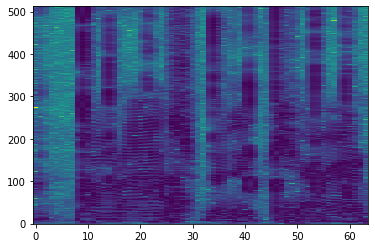

In [15]:
plt.imshow(mb.detach().cpu().numpy()[:, 4, :].T, aspect='auto', origin='lower')
plt.show()